In [18]:
import os
import cv2
from PIL import Image
import numpy as np
import imutils
from imutils import contours
import matplotlib.pyplot as plt
from emnist import extract_training_samples
%matplotlib inline

In [19]:
def image_show(i, data, label):
    x = data[i]  # get the vectorized image
    x = x.reshape((28, 28))  # reshape it into 28x28 format
    print("The image label of index %d is %d." % (i, label[i]))
    plt.imshow(x, cmap="gray")  # show the image

In [20]:
def write_image(image, path):
    img = Image.fromarray(np.array(image), 'L')
    img.save(path)

def saveImages(imagesArray, imagesLabels=None):
    for idx, img in enumerate(imagesArray):
        name = f'{idx}-{imagesLabels[idx]}' if(imagesLabels is not None) else f'{idx}'
        write_image(img, f'test/{name}.png')

In [21]:
# data is a numpy array of shape (x,y,z) => (x, y*z)
def flatten3d(data):
    dims = data.shape[1] * data.shape[2]
    data = data.reshape(data.shape[0], dims)
    return data

In [22]:
def distance(x,y):
    return np.linalg.norm(x-y)

In [23]:
# for small letter a..z
def getLetterIdx(letter):
    return ord(letter) - ord('a') + 1

getLetterIdx('q')

17

In [24]:
def kNN(x, k, data, label):
    #create a list of distances between the given image and the images of the training set
    distances =[distance(x, data[i]) for i in range(len(data))]
    # Use "np.argpartition". It does not sort the entire array. 
    # It only guarantees that the kth element is in sorted position 
    # and all smaller elements will be moved before it. 
    # Thus the first k elements will be the k-smallest elements.
    idx = np.argpartition(distances, k)
    clas, freq = np.unique(label[idx[:k]], return_counts=True)
    return clas[np.argmax(freq)]

In [25]:
def accuracy_set(data, label, train_data, train_label, k):
    cnt = 0
    predictions = []
    # print(f"labels: {label}")
    for x, lab in zip(data, label):
        pred = kNN(x, k, train_data, train_label)
        predictions.append(pred)
        if pred == lab:
            cnt += 1
    # print(f"predec: {predictions}")
    # return f"{cnt/len(label) * 100}%"
    return [pred, cnt/len(label)]

In [26]:
# extract letters and digits datasets
letters_train, letters_labels_train = extract_training_samples("letters")
digits_train, digits_labels_train = extract_training_samples("digits")
balanced_train, balanced_labels_train = extract_training_samples("balanced")

# Check shape of training data
print(letters_train.shape)
print(digits_train.shape)
print(balanced_train.shape)

# Check shape of training labels
print(letters_labels_train.shape)
print(digits_labels_train.shape)
print(balanced_labels_train.shape)

print(f"min: {min(balanced_labels_train)}, max: {max(balanced_labels_train)}")

(124800, 28, 28)
(240000, 28, 28)
(112800, 28, 28)
(124800,)
(240000,)
(112800,)
min: 0, max: 46


In [27]:
# Flatten Data and Tests
letters_train = flatten3d(letters_train)
digits_train = flatten3d(digits_train)
balanced_train = flatten3d(balanced_train)

print("Training Letters Shape:", letters_train.shape)
print("Training Digits Shape:", digits_train.shape)
print("Training Balanced Shape:", balanced_train.shape)

Training Letters Shape: (124800, 784)
Training Digits Shape: (240000, 784)
Training Balanced Shape: (112800, 784)


The image label of index 3509 is 41.


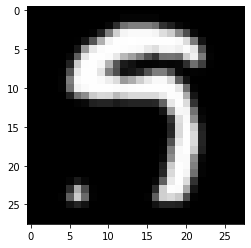

In [28]:
# classes[0..9] are digits
# classes[10..35] are [A..Z]
# classes[36..46] are [a,b,d,e,f,g,h,n,q,r,t]
idx = np.where(balanced_labels_train == 41)
image_show(idx[0][80], balanced_train, balanced_labels_train)

In [29]:
def get_digits(plate_dir='plate'):
    data = []
    files = []
    for filename in os.listdir(plate_dir):
        files.append(filename)
    files.sort()
    for filename in files:
        img = cv2.imread(f'{plate_dir}/{filename}')
        img = 255 - img
        img = cv2.resize(img, (28, 28))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # plt.imshow(img, cmap="gray")
        img = img.flatten()
        predictions = [0 for i in range(0, 9+1)]
        for k in [3, 5, 7]:
            pred = kNN(img, k, digits_train, digits_labels_train)
            predictions[pred] += 1
        maxIdx = predictions.index(max(predictions))         
        data.append(str(maxIdx))
    return data

In [30]:
def get_letters(plate_dir):
    data = []
    files = []
    for filename in os.listdir(plate_dir):
        files.append(filename)
    files.sort()
    for filename in files:
        img = cv2.imread(f'{plate_dir}/{filename}')
        img = 255 - img
        img = cv2.resize(img, (28, 28))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # plt.imshow(img, cmap="gray")
        img = img.flatten()
        predictions = [0 for i in range(0, 26+1)]
        for k in [3, 5, 7]:
            pred = kNN(img, k, letters_train, letters_labels_train)
            predictions[pred] += 1
        maxIdx = predictions.index(max(predictions))         
        data.append(chr(maxIdx + ord('a') - 1))
    return data

In [31]:
def get_balanced(plate_dir):
    data = []
    files = []
    labels = \
        [x for x in range(0, 9+1)] + \
        [chr(x+ord('A')) for x in range(0,25+1)] + \
        ['a','b','d','e','f','g','h','n','q','r','t']
    for filename in os.listdir(plate_dir):
        files.append(filename)
    files.sort()
    for filename in files:
        img = cv2.imread(f'{plate_dir}/{filename}')
        img = 255 - img
        img = cv2.resize(img, (28, 28))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # plt.imshow(img, cmap="gray")
        img = img.flatten()
        predictions = [0 for i in range(len(labels))]
        for k in [3, 5, 7]:
            pred = kNN(img, k, balanced_train, balanced_labels_train)
            predictions[pred] += 1
        maxIdx = predictions.index(max(predictions))         
        data.append(labels[maxIdx])
    return data

In [32]:
# takes RGB cropped plate number like images/pic1.jpg
def extract_text(cropped_plate):
    image = cv2.imread(cropped_plate)
    mask = np.zeros(image.shape, dtype=np.uint8)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    (cnts, _) = imutils.contours.sort_contours(cnts, method="left-to-right")
    ROI_number = 0
    for c in cnts:
        area = cv2.contourArea(c)
        if area < 800 and area > 200:
            x,y,w,h = cv2.boundingRect(c)
            ROI = 255 - thresh[y:y+h, x:x+w]
            cv2.drawContours(mask, [c], -1, (255,255,255), -1)
            cv2.imwrite('images/plate/ROI_{}.png'.format(ROI_number), ROI)
            ROI_number += 1

    plt.imshow(mask, cmap="gray")
    plt.imshow(thresh, cmap="gray")

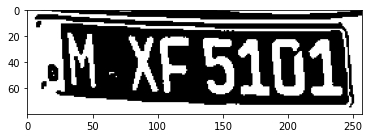

In [33]:
extract_text('images/pic1.jpg')

In [34]:
# best is to use balanced dataset
res = get_balanced('images/plate')
res

['M', 'X', 'F', 5, 'I', 'B', 'I']

In [35]:
res = get_digits('images/plate')
print(res)

['0', '8', '6', '5', '2', '0', '2']


In [36]:
res = get_letters('images/plate')
print(res)

['m', 'x', 'f', 'b', 'i', 'u', 'z']
